In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

C:\Users\emily\AppData\Local\Temp\ipykernel_25024\4129296602.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
all_classes = Base.classes
for cls_name in all_classes.keys():
    print(cls_name)

measurement
station


In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

# Extract the date value from the result
most_recent_date = most_recent_date[0] if most_recent_date else None

print("The most recent date in the dataset is:", most_recent_date)


The most recent date in the dataset is: 2017-08-23


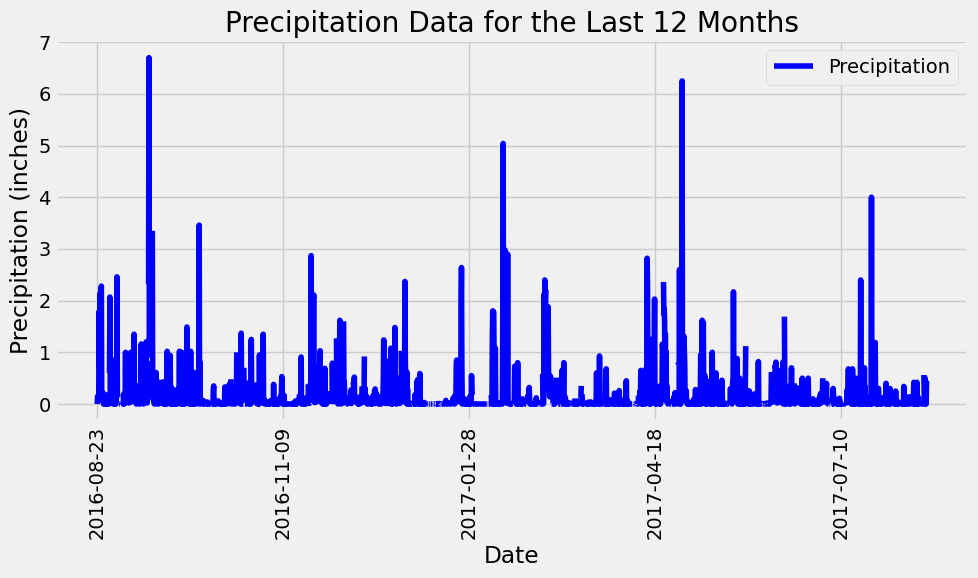

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')  # Convert to string

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago_str)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Plot the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6), color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df.describe()

# Print the summary statistics
print(summary_statistics)


       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Print the stations and their counts in descending order
print("Most active stations:")
for station, count in most_active_stations:
    print(station,count)

Most active stations:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Most active station ID: {most_active_station_id}")
print(f"Lowest temperature: {lowest_temp} F")
print(f"Highest temperature: {highest_temp} F")
print(f"Average temperature: {avg_temp} F")

Most active station ID: USC00519281
Lowest temperature: 54.0 F
Highest temperature: 85.0 F
Average temperature: 71.66378066378067 F


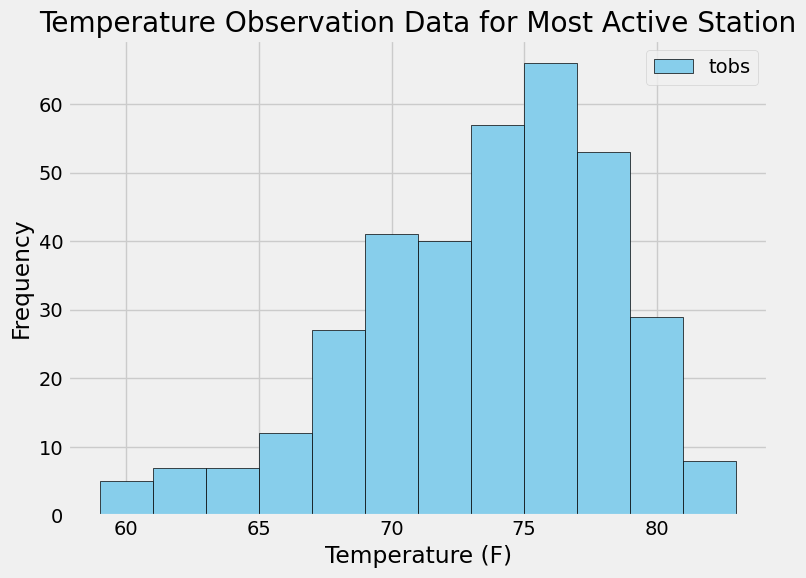

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago_str)\
    .all()

# Extract temperatures from the result
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observation Data for Most Active Station')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()